In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

metricas = {"logistic_regression": {}, "decision_tree": {}, "svm": {}, "keras": {}}
df = pd.read_csv("banking.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [ ]:
df["education"] = np.where(df["education"] == "basic.9y", "Basic", df["education"])
df["education"] = np.where(df["education"] == "basic.6y", "Basic", df["education"])
df["education"] = np.where(df["education"] == "basic.4y", "Basic", df["education"])

In [3]:
df.education.unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [4]:
df.y.value_counts(normalize=True).round(2)

y
0    0.89
1    0.11
Name: proportion, dtype: float64

In [5]:
df.groupby("y").mean(numeric_only=True).T.round(2)

y,0,1
age,39.91,40.91
duration,220.84,553.19
campaign,2.63,2.05
pdays,984.11,792.04
previous,0.13,0.49
emp_var_rate,0.25,-1.23
cons_price_idx,93.60,93.35
cons_conf_idx,-40.59,-39.79
euribor3m,3.81,2.12
nr_employed,5176.17,5095.12


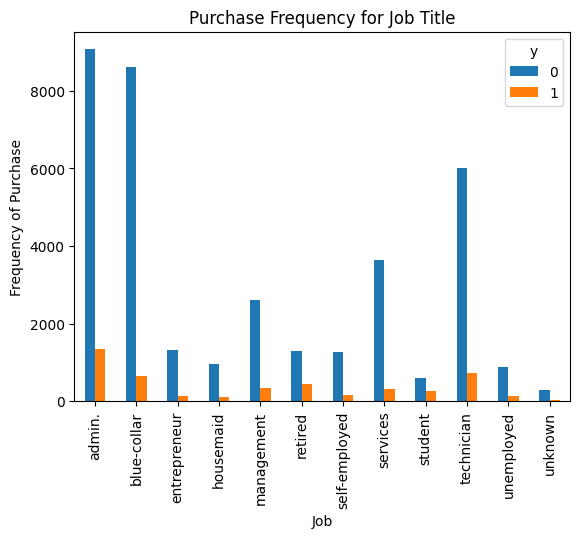

In [6]:
pd.crosstab(df.job, df.y).plot(kind="bar")
plt.title("Purchase Frequency for Job Title")
plt.xlabel("Job")
plt.ylabel("Frequency of Purchase")
plt.savefig("purchase_fre_job")

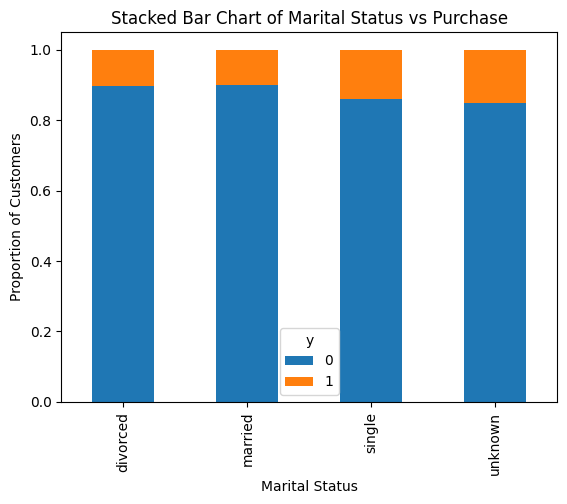

In [7]:
table = pd.crosstab(df.marital, df.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Stacked Bar Chart of Marital Status vs Purchase")
plt.xlabel("Marital Status")
plt.ylabel("Proportion of Customers")
plt.savefig("mariral_vs_pur_stack")

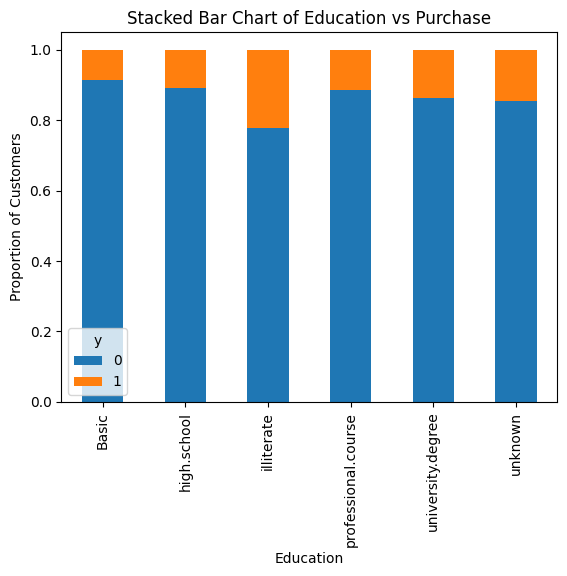

In [8]:
table = pd.crosstab(df.education, df.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Stacked Bar Chart of Education vs Purchase")
plt.xlabel("Education")
plt.ylabel("Proportion of Customers")
plt.savefig("edu_vs_pur_stack")

In [9]:
df.select_dtypes(exclude=["object"]).columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


X = df.drop("y", axis=1)
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_vars = X.select_dtypes(include=["object"]).columns.tolist()
num_vars = X.select_dtypes(exclude=["object"]).columns.tolist()
ct = ColumnTransformer(
    transformers=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"), cat_vars),
        ("scaler", StandardScaler(), num_vars),
    ],
    remainder="passthrough",
)

# 3. TRANSFORMAR DESPUÉS
X_train = ct.fit_transform(X_train)

# SOLO Transform en test (usa lo aprendido de X_train, no aprende nada nuevo)
X_test = ct.transform(X_test)

In [4]:
print(ct.get_feature_names_out())

['encoder__job_admin.' 'encoder__job_blue-collar'
 'encoder__job_entrepreneur' 'encoder__job_housemaid'
 'encoder__job_management' 'encoder__job_retired'
 'encoder__job_self-employed' 'encoder__job_services'
 'encoder__job_student' 'encoder__job_technician'
 'encoder__job_unemployed' 'encoder__job_unknown'
 'encoder__marital_divorced' 'encoder__marital_married'
 'encoder__marital_single' 'encoder__marital_unknown'
 'encoder__education_Basic' 'encoder__education_high.school'
 'encoder__education_illiterate' 'encoder__education_professional.course'
 'encoder__education_university.degree' 'encoder__education_unknown'
 'encoder__default_no' 'encoder__default_unknown' 'encoder__default_yes'
 'encoder__housing_no' 'encoder__housing_unknown' 'encoder__housing_yes'
 'encoder__loan_no' 'encoder__loan_unknown' 'encoder__loan_yes'
 'encoder__contact_cellular' 'encoder__contact_telephone'
 'encoder__month_apr' 'encoder__month_aug' 'encoder__month_dec'
 'encoder__month_jul' 'encoder__month_jun' 'en

In [4]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# 1. Configurar el modelo y la validación cruzada
logreg = LogisticRegression(max_iter=1000, random_state=42)
cv = StratifiedKFold(5)

# 2. Ejecutar RFECV
rfecv = RFECV(estimator=logreg, step=1, cv=cv, scoring="accuracy", n_jobs=-1)

rfecv.fit(X_train, y_train)

# 3. Mostrar resultados
print(f"Número óptimo de características: {rfecv.n_features_}")

# Recuperar los nombres de las columnas para saber cuáles ganaron
nombres_columnas = ct.get_feature_names_out()
variables_ganadoras = nombres_columnas[rfecv.support_]

print("\nTop 5 variables seleccionadas:")
print(variables_ganadoras[:5])

Número óptimo de características: 50

Top 5 variables seleccionadas:
['encoder__job_blue-collar' 'encoder__job_entrepreneur'
 'encoder__job_retired' 'encoder__job_self-employed'
 'encoder__job_services']


In [5]:
from sklearn.metrics import roc_auc_score

print("Tamaño original de X_train:", X_train.shape)
# 4. Reducir los conjuntos de datos
X_train = X_train[:, rfecv.support_]
X_test = X_test[:, rfecv.support_]

# 5. Entrenar el modelo final con los datos optimizados
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
print("Tamaño de X_train después de RFECV:", X_train.shape)
# 6. Evaluar
score = logreg.score(X_test, y_test)
print(f"\nAccuracy final con {rfecv.n_features_} variables: {score:.4f}")
metricas["logistic_regression"]["accuracy"] = score
roc = roc_auc_score(y_test, logreg.predict(X_test))
print(f"AUC ROC final con {rfecv.n_features_} variables: {roc:.4f}")
metricas["logistic_regression"]["roc_auc"] = roc

Tamaño original de X_train: (32950, 61)
Tamaño de X_train después de RFECV: (32950, 50)

Accuracy final con 50 variables: 0.9079
AUC ROC final con 50 variables: 0.6996


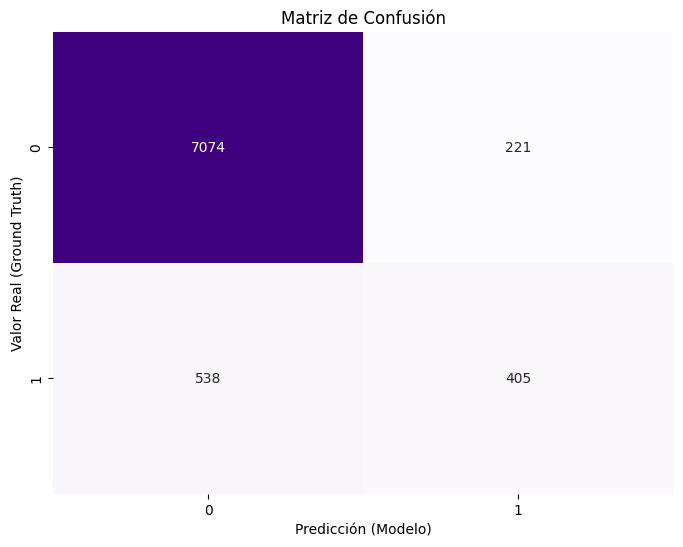

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcular matriz
y_pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", cbar=False)

plt.xlabel("Predicción (Modelo)")
plt.ylabel("Valor Real (Ground Truth)")
plt.title("Matriz de Confusión")
plt.show()

AUC ROC: 0.699592829673864


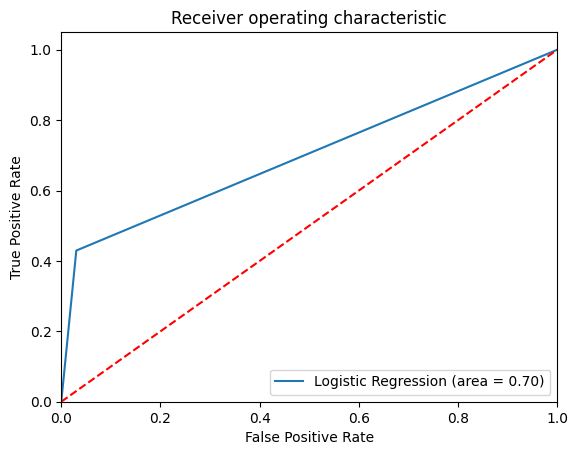

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, y_pred)
print("AUC ROC:", logit_roc_auc)
metricas["logistic_regression"]["AUC_ROC"] = logit_roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [11]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("El score del modelo es:", accuracy_score(y_test, y_pred))
metricas["decision_tree"]["accuracy"] = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
roc = roc_auc_score(y_test, y_pred)
print("AUC ROC:", roc)
metricas["decision_tree"]["AUC_ROC"] = roc

El score del modelo es: 0.9110220927409566
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7295
           1       0.65      0.48      0.55       943

    accuracy                           0.91      8238
   macro avg       0.79      0.72      0.75      8238
weighted avg       0.90      0.91      0.91      8238

AUC ROC: 0.7235356368523307


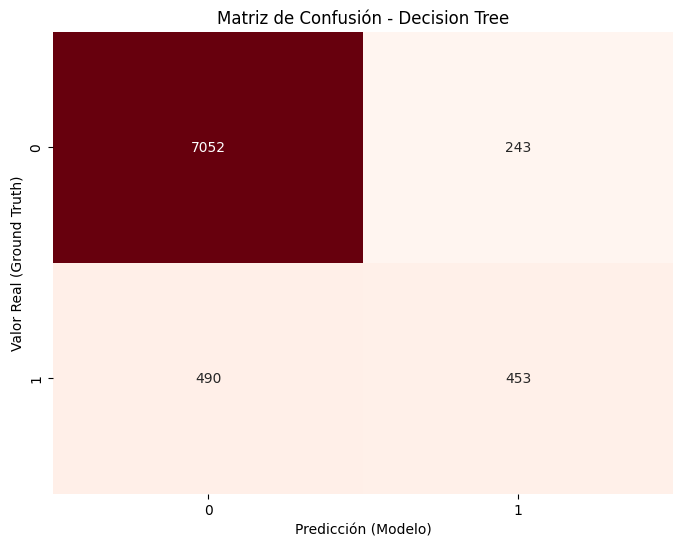

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel("Predicción (Modelo)")
plt.ylabel("Valor Real (Ground Truth)")
plt.title("Matriz de Confusión - Decision Tree")
plt.show()

In [13]:
svm = SVC(kernel="linear", probability=True, random_state=42)
svm.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


El score del modelo es: 0.9017965525613013
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7295
           1       0.63      0.34      0.44       943

    accuracy                           0.90      8238
   macro avg       0.78      0.66      0.69      8238
weighted avg       0.89      0.90      0.89      8238

AUC ROC: 0.65784616927732


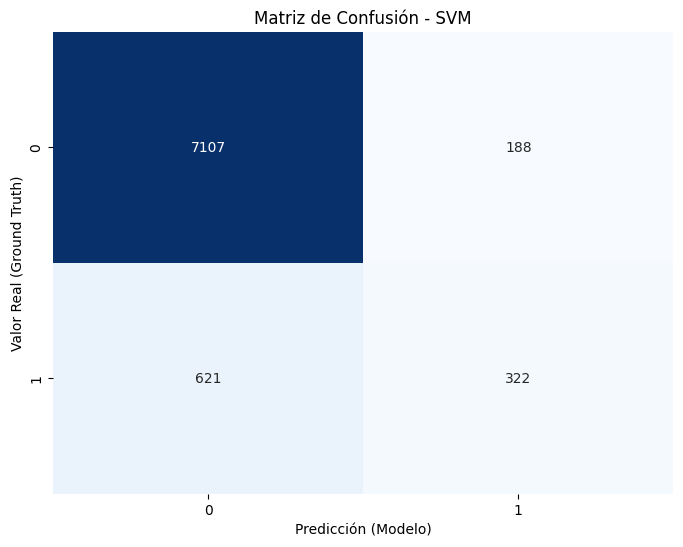

In [14]:
y_pred = svm.predict(X_test)
print("El score del modelo es:", accuracy_score(y_test, y_pred))
metricas["svm"]["accuracy"] = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
roc = roc_auc_score(y_test, y_pred)
print("AUC ROC:", roc)
metricas["svm"]["AUC_ROC"] = roc
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicción (Modelo)")
plt.ylabel("Valor Real (Ground Truth)")
plt.title("Matriz de Confusión - SVM")
plt.show()

El score del modelo es: 0.9015537751881525
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7295
           1       0.59      0.45      0.51       943

    accuracy                           0.90      8238
   macro avg       0.76      0.70      0.73      8238
weighted avg       0.89      0.90      0.90      8238

AUC ROC: 0.7029539836477723


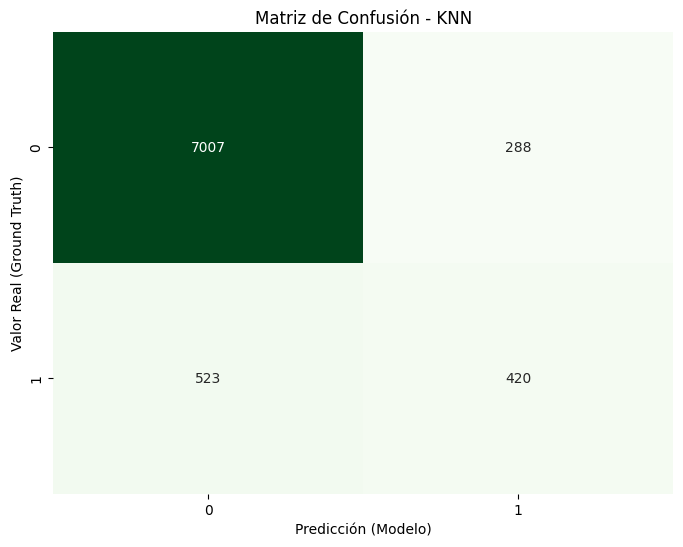

In [15]:
# KNN
metricas["knn"] = {}
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("El score del modelo es:", accuracy_score(y_test, y_pred))
metricas["knn"]["accuracy"] = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
roc = roc_auc_score(y_test, y_pred)
print("AUC ROC:", roc)
metricas["knn"]["AUC_ROC"] = roc
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicción (Modelo)")
plt.ylabel("Valor Real (Ground Truth)")
plt.title("Matriz de Confusión - KNN")
plt.show()

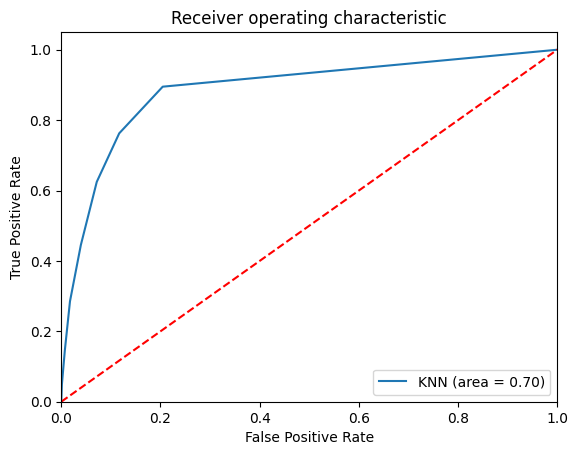

In [16]:
logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="KNN (area = %0.2f)" % logit_roc_auc)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.savefig("Log_ROC")
plt.show()

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Distribución de clases después de SMOTE:")
print(pd.Series(y_train).value_counts())

Distribución de clases después de SMOTE:
y
0    29253
1    29253
Name: count, dtype: int64


In [19]:
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
print("El score del modelo es:", accuracy_score(y_test, y_pred))
roc = roc_auc_score(y_test, y_pred)
print("AUC ROC:", roc)

El score del modelo es: 0.8607671764991502
AUC ROC: 0.8715227894001978


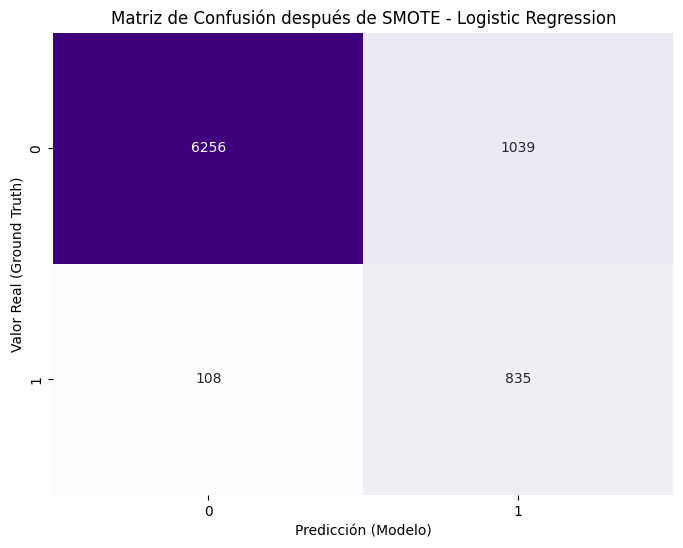

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.xlabel("Predicción (Modelo)")
plt.ylabel("Valor Real (Ground Truth)")
plt.title("Matriz de Confusión después de SMOTE - Logistic Regression")
plt.show()

El score del modelo es: 0.8440155377518815
AUC ROC: 0.8385184436819187


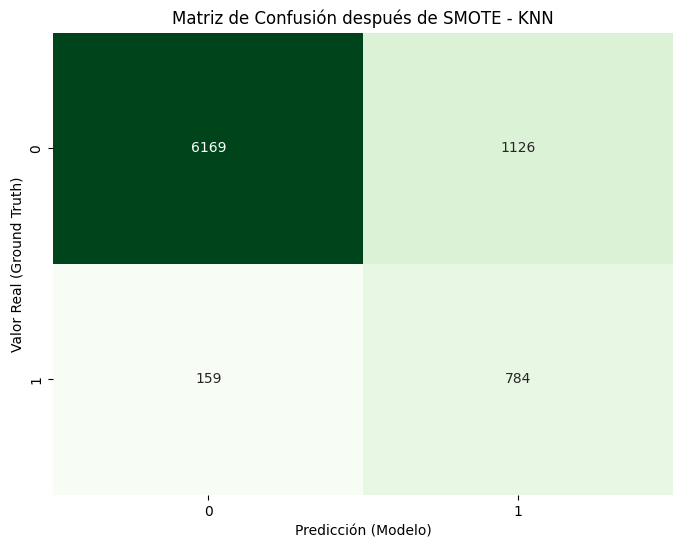

In [21]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("El score del modelo es:", accuracy_score(y_test, y_pred))
roc = roc_auc_score(y_test, y_pred)
print("AUC ROC:", roc)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicción (Modelo)")
plt.ylabel("Valor Real (Ground Truth)")
plt.title("Matriz de Confusión después de SMOTE - KNN")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.optimizers import Adam


df = pd.read_csv("banking.csv")
df["education"] = np.where(df["education"] == "basic.9y", "Basic", df["education"])
df["education"] = np.where(df["education"] == "basic.6y", "Basic", df["education"])
df["education"] = np.where(df["education"] == "basic.4y", "Basic", df["education"])
cat_vars = df.select_dtypes(include=["object"]).columns.tolist()
num_vars = df.select_dtypes(exclude=["object"]).columns.tolist()
num_vars.remove("y")

In [ ]:
encoded = []
inputs = {}
for col in num_vars:
    normalizer = layers.Normalization(axis=None, name=f"{col}_norm")
    normalizer.adapt(df[col].values)
    inputs[col] = layers.Input(shape=(1,), name=col)
    encoded.append(normalizer(inputs[col]))

for col in cat_vars:
    lookup = layers.StringLookup(output_mode="one_hot", name=f"{col}_strlookup")
    lookup.adapt(df[col].astype(str).values)  # Aprende el vocabulario
    inputs[col] = layers.Input(
        shape=(1,), dtype=tf.string, name=col
    )  # Declara la entrada
    encoded.append(lookup(inputs[col]))  # Aplica el lookup dentro del modelo

X_train_dict = {}
X_test_dict = {}

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("y", axis=1), df["y"], test_size=0.2, random_state=42
)
# Columnas numéricas
for col in num_vars:
    X_train_dict[col] = X_train[col].values
    X_test_dict[col] = X_test[col].values

for col in cat_vars:
    X_train_dict[col] = X_train[col].astype(str).values
    X_test_dict[col] = X_test[col].astype(str).values

X_train, X_test = X_train_dict, X_test_dict

In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    # 1. Baja el LR si se estanca
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.9, patience=7, min_lr=1e-6, verbose=1
    ),
    # 2. Detiene y restaura si no hay remedio
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    # 3. Guarda una copia física solo de los mejores pesos (seguridad extra)
    ModelCheckpoint(
        "best_classification.weights.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    ),
]

x = layers.concatenate(encoded)
x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, output)
model.compile(
    optimizer=Adam(learning_rate=1e-1),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8704 - loss: 0.2978 - val_accuracy: 0.8932 - val_loss: 0.3386 - learning_rate: 0.1000
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9058 - loss: 0.2006 - val_accuracy: 0.8988 - val_loss: 0.2438 - learning_rate: 0.1000
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9055 - loss: 0.2010 - val_accuracy: 0.9140 - val_loss: 0.2072 - learning_rate: 0.1000
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9056 - loss: 0.1929 - val_accuracy: 0.9132 - val_loss: 0.2156 - learning_rate: 0.1000
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9070 - loss: 0.1909 - val_accuracy: 0.9088 - val_loss: 0.1962 - learning_rate: 0.1000
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9082 - loss: 0.1894 - val_accuracy: 0.9152 - val_loss: 0.2020 - learning_rate: 0.1000
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9094 - loss: 0

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy del modelo Keras: 0.9118
AUC ROC del modelo Keras: 0.7618


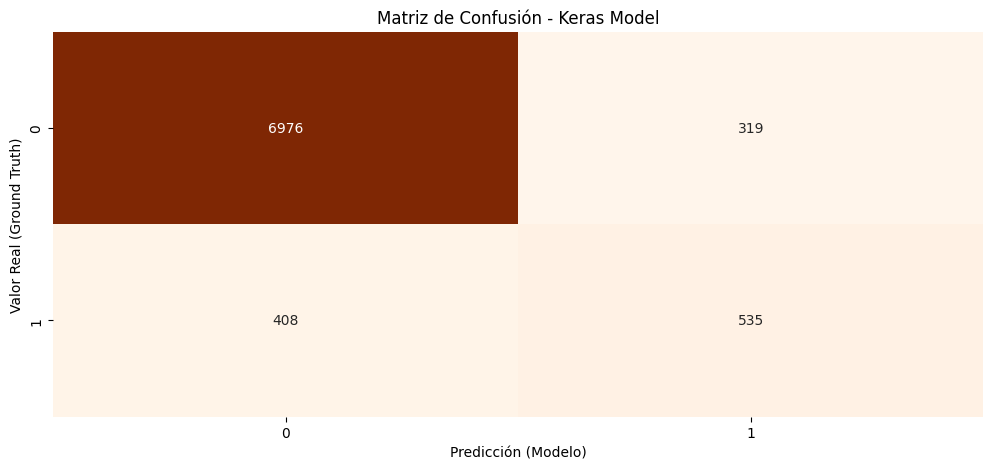

In [51]:
y_pred = model.predict(X_test).round()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo Keras: {accuracy:.4f}")
metricas["keras"]["accuracy"] = accuracy
roc = roc_auc_score(y_test, y_pred)
print(f"AUC ROC del modelo Keras: {roc:.4f}")
metricas["keras"]["AUC_ROC"] = roc
plt.figure(figsize=(12, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicción (Modelo)")
plt.ylabel("Valor Real (Ground Truth)")
plt.title("Matriz de Confusión - Keras Model")
plt.show()

In [52]:
# Mostrar ordenado por mayor AUC
for llave, valor in sorted(
    metricas.items(), key=lambda item: item[1]["AUC_ROC"], reverse=True
):
    print(f"Modelo: {llave}")
    for metrica, valor_metrica in valor.items():
        print(f"  {metrica}: {valor_metrica:.4f}")

Modelo: keras
  accuracy: 0.9118
  AUC_ROC: 0.7618
Modelo: decision_tree
  accuracy: 0.9110
  AUC_ROC: 0.7235
Modelo: knn
  accuracy: 0.9016
  AUC_ROC: 0.7030
Modelo: logistic_regression
  accuracy: 0.9079
  AUC_ROC: 0.6996
Modelo: svm
  accuracy: 0.9018
  AUC_ROC: 0.6578
